<a href="https://colab.research.google.com/github/nnikolovskiii/Deep-learning-lab-exercises/blob/master/2_Node_Classification(Cora_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.1.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [48]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from tqdm import tqdm

In [49]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [50]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_gcn_layers=1):
        super().__init__()
        torch.manual_seed(1234567)
        self.layers = torch.nn.ModuleList()
        self.num_layers = num_gcn_layers

        self.layers.append(GCNConv(dataset.num_features, hidden_channels))

        for _ in range(self.num_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))

        self.layers.append(GCNConv(hidden_channels, dataset.num_classes))

    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.layers[-1](x, edge_index)
        return x

#Using validation
To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

In [51]:
def train(model, optimizer, criterion):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(model, optimizer, criterion, test=True):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      if test:
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      else:
        test_correct = pred[data.val_mask] == data.y[data.val_mask]
        test_acc = int(test_correct.sum()) / int(data.val_mask.sum())
      return test_acc


model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(1, 101):
    loss = train(model, optimizer, criterion)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [52]:
test_acc = test(model, optimizer, criterion)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


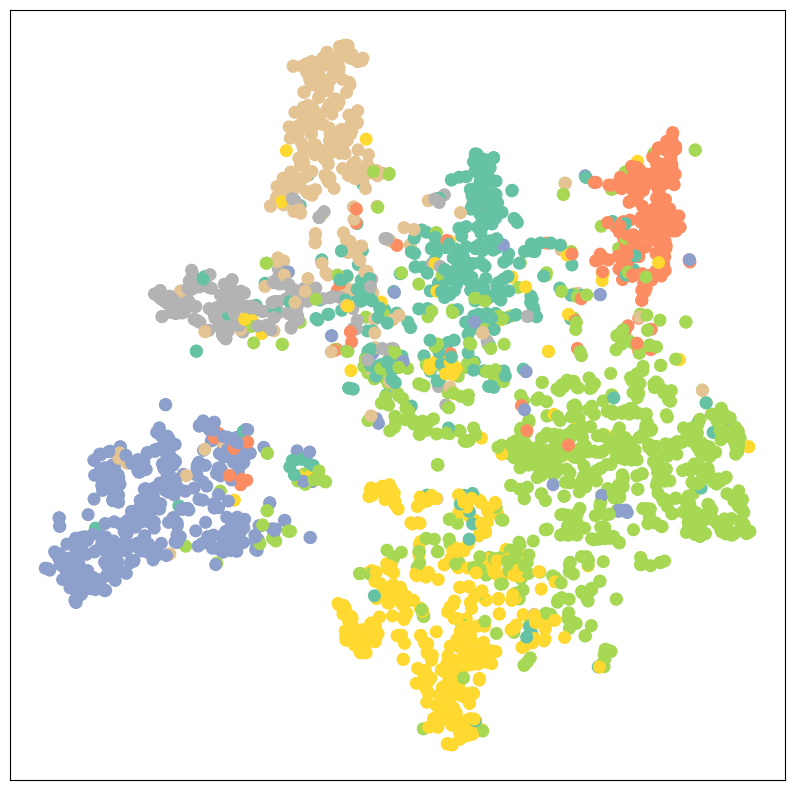

In [53]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [54]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

max_val = None
best_model_state = None
for epoch in range(1, 101):
    loss = train(model, optimizer, criterion)
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    val_acc = test(model, optimizer, criterion, False)
    if max_val == None or max_val<val_acc:
      max_val = val_acc
      best_model_state = model.state_dict()

In [55]:
model.load_state_dict(best_model_state)
test_acc = test(model, optimizer, criterion)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


#Increasing the hidden layers in GCN
How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

In [56]:
def plot_accuracy(accuracies):
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs. Epoch')
    plt.show()

In [57]:
test_accuracies = []

for num_layers in range(1, 6):
    model = GCN(16, num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    max_val = None
    best_model_state = None

    for epoch in tqdm(range(1,100+1), desc='Training', unit='epoch'):
        loss = train(model, optimizer, criterion)
        val_acc = test(model, optimizer, criterion, False)

        if max_val is None or max_val < val_acc:
            max_val = val_acc
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    test_acc = test(model, optimizer, criterion)
    print(f'Test Accuracy (Layers={num_layers}): {test_acc:.4f}')
    test_accuracies.append(test_acc)


Training: 100%|██████████| 100/100 [00:01<00:00, 53.12epoch/s]


Test Accuracy (Layers=1): 0.8150


Training: 100%|██████████| 100/100 [00:02<00:00, 48.71epoch/s]


Test Accuracy (Layers=2): 0.7780


Training: 100%|██████████| 100/100 [00:02<00:00, 41.50epoch/s]


Test Accuracy (Layers=3): 0.6870


Training: 100%|██████████| 100/100 [00:03<00:00, 29.37epoch/s]


Test Accuracy (Layers=4): 0.6090


Training: 100%|██████████| 100/100 [00:03<00:00, 32.88epoch/s]

Test Accuracy (Layers=5): 0.5330


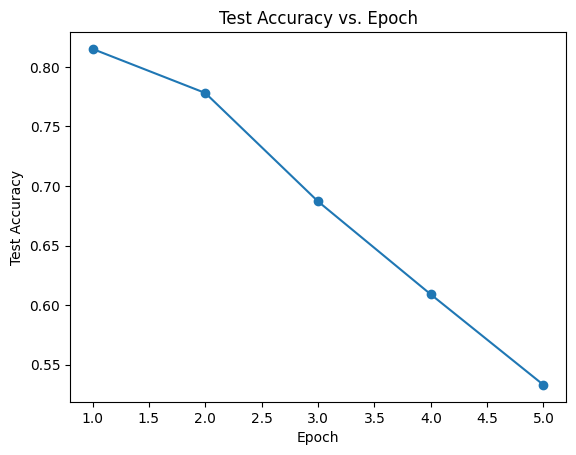

In [58]:
plot_accuracy(test_accuracies)

#Using GATConv instead of GCNConv
You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [68]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=8)
        self.conv2 = GATConv(8 * hidden_channels, dataset.num_classes, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [69]:
model = GAT(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

max_val = None
best_model_state = None
for epoch in range(1, 101):
    loss = train(model, optimizer, criterion)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    val_acc = test(model, optimizer, criterion, False)
    if max_val == None or max_val<val_acc:
      max_val = val_acc
      best_model_state = model.state_dict()

Epoch: 001, Loss: 1.9445
Epoch: 002, Loss: 1.9268
Epoch: 003, Loss: 1.9029
Epoch: 004, Loss: 1.8800
Epoch: 005, Loss: 1.8570
Epoch: 006, Loss: 1.8426
Epoch: 007, Loss: 1.8082
Epoch: 008, Loss: 1.7840
Epoch: 009, Loss: 1.7602
Epoch: 010, Loss: 1.7252
Epoch: 011, Loss: 1.6861
Epoch: 012, Loss: 1.6548
Epoch: 013, Loss: 1.6103
Epoch: 014, Loss: 1.6038
Epoch: 015, Loss: 1.5454
Epoch: 016, Loss: 1.4905
Epoch: 017, Loss: 1.4855
Epoch: 018, Loss: 1.4246
Epoch: 019, Loss: 1.3940
Epoch: 020, Loss: 1.3484
Epoch: 021, Loss: 1.2987
Epoch: 022, Loss: 1.2663
Epoch: 023, Loss: 1.1919
Epoch: 024, Loss: 1.1645
Epoch: 025, Loss: 1.0948
Epoch: 026, Loss: 1.0523
Epoch: 027, Loss: 1.0373
Epoch: 028, Loss: 0.9975
Epoch: 029, Loss: 0.9699
Epoch: 030, Loss: 0.9118
Epoch: 031, Loss: 0.8399
Epoch: 032, Loss: 0.8478
Epoch: 033, Loss: 0.7622
Epoch: 034, Loss: 0.7360
Epoch: 035, Loss: 0.7445
Epoch: 036, Loss: 0.6977
Epoch: 037, Loss: 0.6970
Epoch: 038, Loss: 0.6556
Epoch: 039, Loss: 0.5993
Epoch: 040, Loss: 0.5918


In [70]:
model.load_state_dict(best_model_state)
test_acc = test(model, optimizer, criterion)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7850


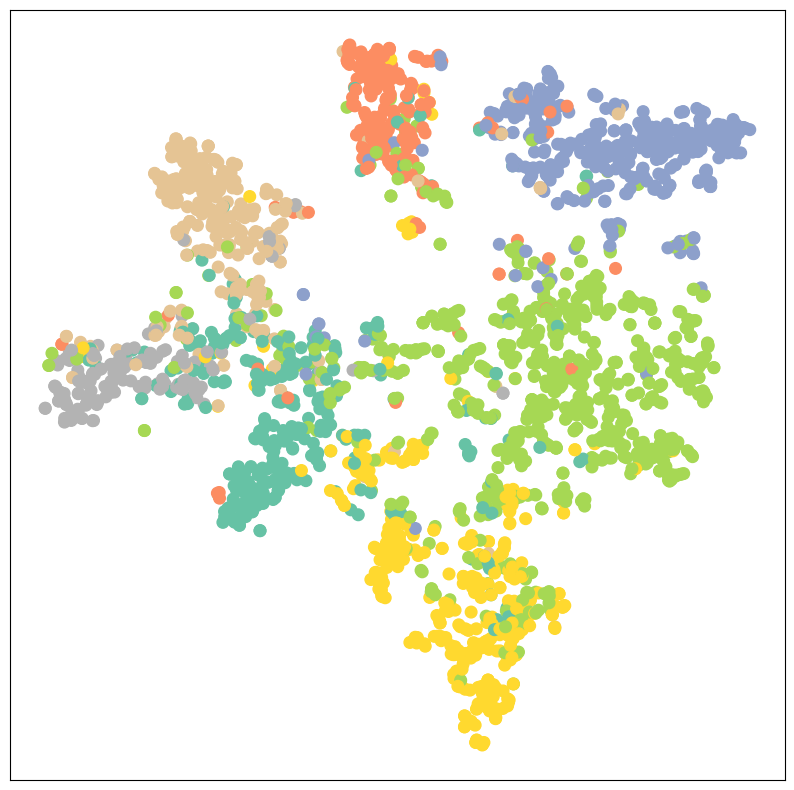

In [71]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)